In [20]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2020.deeplearning/master/init.py
from init import init; init(force_download=False)

In [21]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle, bz2
from local.lib import mlutils
%matplotlib inline

## Check the following article on network architectures

- https://towardsdatascience.com/illustrated-10-cnn-architectures-95d78ace614d

In particular, 

- GlobalAveragePooling
- 1x1 convolutions
- Skip connections
- Networks modules:
    - **Inception**: multiple filter sizes on the same level (see [here](https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202))
    - **Resnet**: learns residuals, gradients back propagate larger to earlier layers (see [here](https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec))
    - **Xception**: depthwise separable convolutions (see [here](https://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec))
    

# Task: Use a Tensorflow hub model for image feature vector extraction

- browse this page, https://www.tensorflow.org/hub/common_signatures/images#image_feature_vector
- select a TF2.0 model that provides feature vector
- load and resize the mini-cifar2 dataset to the image size required by the selected model (see [`skimage.transform.resize`](https://scikit-image.org/docs/dev/api/skimage.transform.html?ref=driverlayer.com/web#skimage.transform.resize))
- apply the selected model layer to the resized mini-cifar2 dataset
- use any classical method from `scikit-learn` to create a classifier

In [22]:
!wget -nc https://s3.amazonaws.com/rlx/mini_cifar_2.h5

File ‘mini_cifar_2.h5’ already there; not retrieving.



(0.0, 1.0)

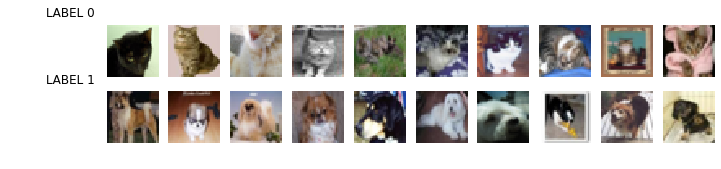

In [23]:
import h5py
with h5py.File('mini_cifar_2.h5','r') as h5f:
    x_cifar = h5f["x"][:][:1000]
    y_cifar = h5f["y"][:][:1000]
    
x_cifar = x_cifar[y_cifar!=2]    
y_cifar = y_cifar[y_cifar!=2]    
mlutils.show_labeled_image_mosaic(x_cifar, y_cifar)
np.min(x_cifar), np.max(x_cifar)

In [24]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_cifar, y_cifar, test_size=.2)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print("\ndistribution of train classes")
print(pd.Series(y_train).value_counts())
print("\ndistribution of test classes")
print(pd.Series(y_test).value_counts())

(800, 32, 32, 3) (800,) (200, 32, 32, 3) (200,)

distribution of train classes
0    404
1    396
dtype: int64

distribution of test classes
1    101
0     99
dtype: int64


## Observe how we can apply a model to input data

- this example shows an untrained model
- you will have to do similarly with tfhub models

In [25]:
m = tf.keras.Sequential()
m.add(tf.keras.layers.InputLayer((32,32,3)))
m.add(tf.keras.layers.Flatten())
m.add(tf.keras.layers.Dense(20, activation="sigmoid"))


In [26]:
output = m(x_train.astype(np.float32)).numpy()
output.shape

(800, 20)

In [27]:
output

array([[0.30722076, 0.6111934 , 0.57461745, ..., 0.2922887 , 0.32347628,
        0.23817873],
       [0.34534714, 0.6649573 , 0.6310839 , ..., 0.2627891 , 0.42366982,
        0.33634883],
       [0.4259639 , 0.7070227 , 0.5542538 , ..., 0.3154334 , 0.44556728,
        0.3013954 ],
       ...,
       [0.39904028, 0.8225664 , 0.63258886, ..., 0.20534529, 0.290671  ,
        0.2573988 ],
       [0.2288965 , 0.69835144, 0.43119296, ..., 0.25206095, 0.28392574,
        0.20040935],
       [0.3247664 , 0.65251595, 0.4444472 , ..., 0.29868823, 0.3924206 ,
        0.34198803]], dtype=float32)

## Your solution here

In [37]:
!pip install "tensorflow>=2.0.0
!pip install --upgrade tensorflow-hub

/bin/sh: 1: Syntax error: Unterminated quoted string
    100% |████████████████████████████████| 102kB 1.1MB/s a 0:00:01


In [41]:
for i in range(len(x_train[:,0,0,0].shape)):
    x_train[0,:,:,0].shape


(32, 32)

In [152]:
len(x_train[:,0,0,0])

800

In [184]:
import tensorflow_hub as hub
from skimage.transform import resize


img=resize((x_train[0,:,:,0]),(96,96))
x_newtr[0,:,:]=img

#img.shape
x_newtr.shae

TypeError: list indices must be integers or slices, not tuple

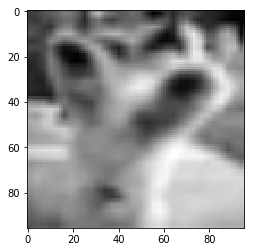

In [179]:
plt.imshow(img[:,:] , cmap='gray');

In [82]:
m = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_050_96/feature_vector/4",
                   trainable=False),  # Can be True, see below.
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
m.build([None, 96, 96, 3])  # Batch input shape.

URLError: <urlopen error [Errno -3] Temporary failure in name resolution>